In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import make_scorer, get_scorer, PrecisionRecallDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [7]:
df_features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)
df_targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))

In [8]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict_proba')   
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)

In [9]:
rf_params = {
    'max_depth': [5, 10, 20, 30, 40],
    'min_samples_leaf': [2,4,8],
    'min_samples_split': [8, 16, 24],
    'criterion': ['gini'],
    'n_estimators': [500],
}
rf_estimators, rf_scores_train, rf_scores_test, rf_cv_results = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_min_samples_split', ylabel='mean_test_f1'>

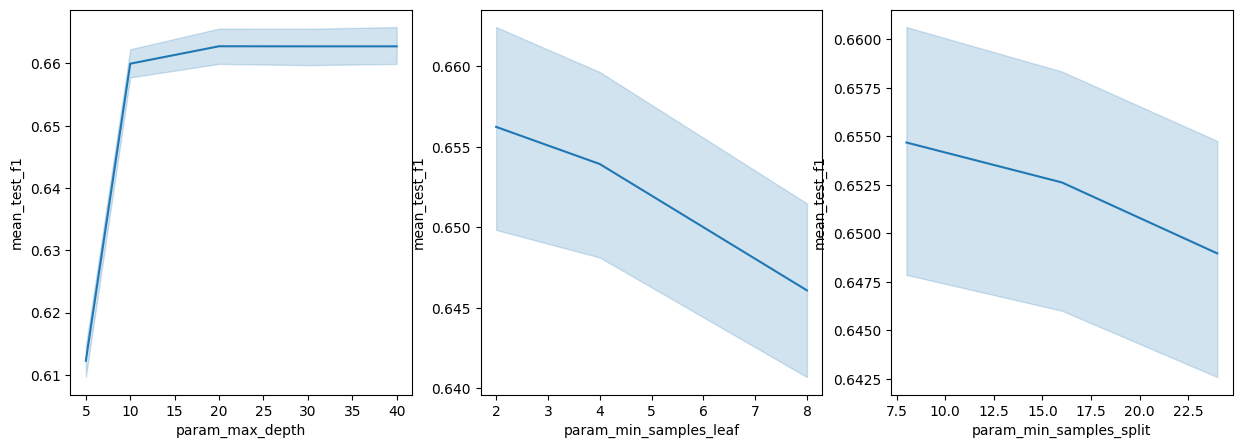

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=rf_cv_results, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=rf_cv_results, x='param_min_samples_leaf', y='mean_test_f1', ax=ax[1])
sb.lineplot(data=rf_cv_results, x='param_min_samples_split', y='mean_test_f1', ax=ax[2])

In [13]:
rf_scores_test

,accuracy,precision,recall,f1,roc_auc
0,0.768136,0.725794,0.681552,0.694202,0.884442
1,0.771525,0.721415,0.679272,0.689220,0.885299
2,0.776798,0.732672,0.671644,0.682406,0.894008


In [14]:
rf_scores_train

,accuracy,precision,recall,f1,roc_auc
0,0.934554,0.952402,0.901769,0.922315,0.994688
1,0.937606,0.954514,0.904838,0.924994,0.994899
2,0.932203,0.952139,0.901130,0.922035,0.994950


In [12]:
print_estimators(rf_estimators)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=15)
RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=15)
RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=15)


In [ ]:
rf_params = {
    'max_depth': [20, 25, 30],
    'min_samples_leaf': [2],
    'min_samples_split': [8],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [500],
}
rf_estimators_2, rf_scores_train_2, rf_scores_test_2, rf_cv_results_2 = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

*
*


In [ ]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.0001, 0.001, 0.1],
    'subsample': [0.1, 0.25, 0.5],
    'min_samples_split': [4], 
    'max_depth': [4, 8],
   
}

gb_estimators, gb_scores_train, gb_scores_test, gb_cv_results = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

*
*
*
*
*


In [85]:
gb_scores_train.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.950608,0.945386,0.930325,0.936361,0.986071
std,0.067663,0.074815,0.095425,0.087164,0.019075
min,0.873693,0.860376,0.823114,0.838076,0.964870
25%,0.879344,0.866555,0.828513,0.843729,0.965484
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
gb_scores_test.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.770347,0.717658,0.692480,0.700849,0.883990
std,0.018917,0.025055,0.016569,0.018802,0.003464
min,0.746893,0.685156,0.672926,0.677404,0.879291
25%,0.753672,0.698103,0.677031,0.684719,0.882239
50%,0.777401,0.724657,0.697461,0.706659,0.884838
75%,0.785068,0.738163,0.706601,0.717260,0.885000
max,0.788701,0.742211,0.708381,0.718201,0.888585


<Axes: xlabel='param_subsample', ylabel='mean_test_f1'>

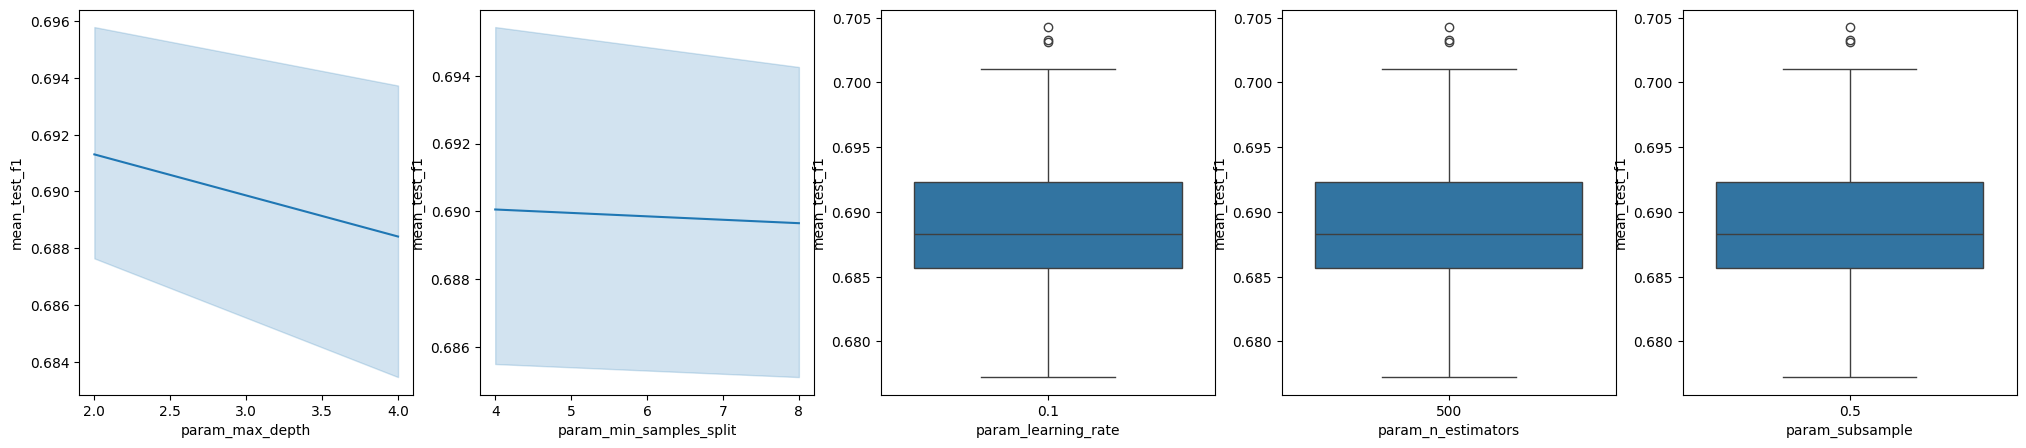

In [88]:
fig, ax = plt.subplots(1,5, figsize=(25,5))
sb.lineplot(data=gb_cv_results, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=gb_cv_results, x='param_min_samples_split', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=gb_cv_results, x='param_learning_rate', y='mean_test_f1', ax=ax[2])
sb.boxplot(data=gb_cv_results, x='param_n_estimators', y='mean_test_f1', ax=ax[3])
sb.boxplot(data=gb_cv_results, x='param_subsample', y='mean_test_f1', ax=ax[4])

In [141]:
print_estimators(gb_estimators)

GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=2, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=4, min_samples_split=8, n_estimators=500,
                           random_state=15, subsample=0.5)


#### GradientBoostingClassifier

In [ ]:
lr_params = {
    'C': [0.1, 1, 1.5, 10],
    "solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"],   
    'tol': [1e-2, 1e-3, 1e-4],
    'max_iter': [100],
}

lr_estimators, lr_scores_train, lr_scores_test, lr_cv_results = train(features_pca32, df_targets,
    LogisticRegression(random_state=global_random_state),
    lr_params, outer_splits=5, inner_splits=4)

In [118]:
lr_scores_test.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.767859,0.713083,0.671210,0.679837,0.880246
std,0.012016,0.020793,0.012752,0.014194,0.005863
min,0.746893,0.679029,0.649184,0.656211,0.869953
25%,0.769492,0.709593,0.672655,0.677965,0.881638
50%,0.771751,0.720040,0.675677,0.686155,0.881757
75%,0.774887,0.723830,0.676673,0.686239,0.883823
max,0.776271,0.732925,0.681859,0.692614,0.884059


In [119]:
lr_scores_train.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.775825,0.723080,0.680648,0.689858,0.889618
std,0.004037,0.006711,0.005803,0.006699,0.000982
min,0.772881,0.716302,0.675416,0.683214,0.888823
25%,0.773100,0.719969,0.676965,0.685743,0.889190
50%,0.773382,0.720785,0.678249,0.687912,0.889345
75%,0.777621,0.724431,0.682842,0.692093,0.889404
max,0.782142,0.733916,0.689768,0.700328,0.891328


<Axes: xlabel='param_solver', ylabel='mean_test_f1'>

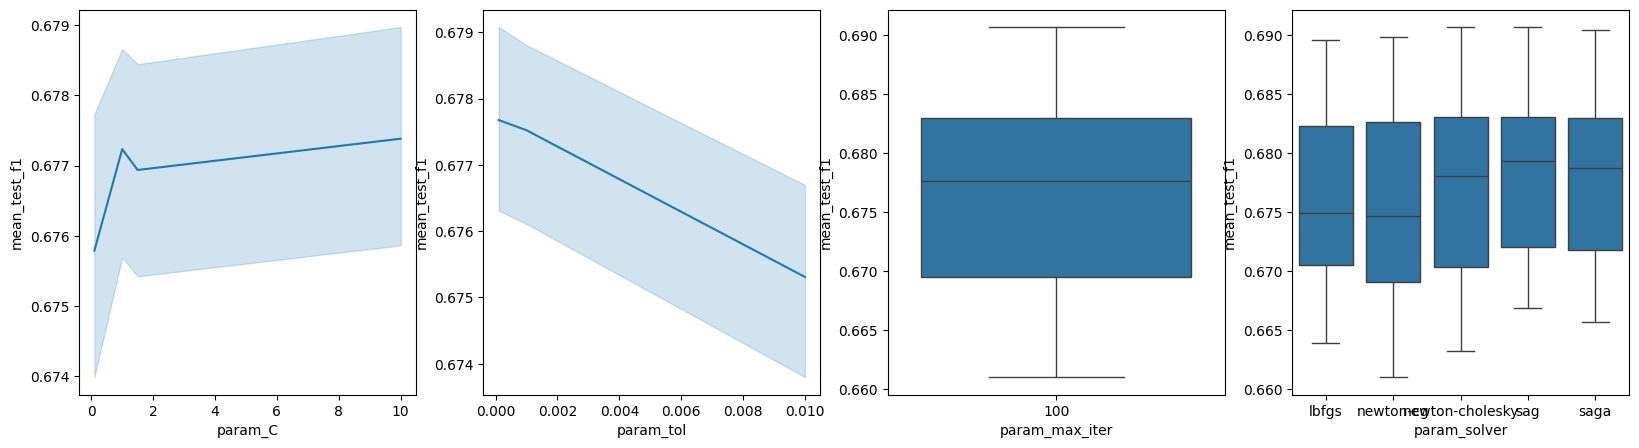

In [120]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sb.lineplot(data=lr_cv_results, x='param_C', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=lr_cv_results, x='param_tol', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=lr_cv_results, x='param_max_iter', y='mean_test_f1', ax=ax[2])
sb.boxplot(data=lr_cv_results, x='param_solver', y='mean_test_f1', ax=ax[3])

In [152]:
print_estimators(lr_estimators)

LogisticRegression(C=1, random_state=15, tol=0.001)
LogisticRegression(C=0.1, random_state=15, solver='newton-cholesky')
LogisticRegression(C=1, random_state=15, solver='saga', tol=0.01)
LogisticRegression(C=10, random_state=15)
LogisticRegression(C=1, random_state=15, solver='saga', tol=0.001)


In [160]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Accuracy:','Precision:','Recall:', 'F1:', 'Roc_auc'],
    'RandomForest Train': [rf_scores_train['accuracy'].mean(),rf_scores_train['precision'].mean(), rf_scores_train['recall'].mean(), rf_scores_train['f1'].mean(), rf_scores_train['roc_auc'].mean()],
    'RandomForest Test': [rf_scores_test['accuracy'].mean(),rf_scores_test['precision'].mean(), rf_scores_test['recall'].mean(), rf_scores_test['f1'].mean(), rf_scores_test['roc_auc'].mean()],
    'Gradient Boosting Train': [gb_scores_train['accuracy'].mean(),gb_scores_train['precision'].mean(), gb_scores_train['recall'].mean(), gb_scores_train['f1'].mean(), gb_scores_train['roc_auc'].mean()],
    'Gradient Boosting Test': [gb_scores_test['accuracy'].mean(),gb_scores_test['precision'].mean(), gb_scores_test['recall'].mean(), gb_scores_test['f1'].mean(), gb_scores_test['roc_auc'].mean()],
    'Logistic Regression Train': [lr_scores_train['accuracy'].mean(),lr_scores_train['precision'].mean(), lr_scores_train['recall'].mean(), lr_scores_train['f1'].mean(), lr_scores_train['roc_auc'].mean()],
    'Logistic Regression Test': [lr_scores_test['accuracy'].mean(),lr_scores_test['precision'].mean(), lr_scores_test['recall'].mean(), lr_scores_test['f1'].mean(), lr_scores_test['roc_auc'].mean()]
    })
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,RandomForest Train,RandomForest Test,Gradient Boosting Train,Gradient Boosting Test,Logistic Regression Train,Logistic Regression Test
Metric,,,,,,
Accuracy:,0.972988,0.778482,0.950608,0.770347,0.775825,0.767859
Precision:,0.980638,0.739022,0.945386,0.717658,0.723080,0.713083
Recall:,0.960067,0.687628,0.930325,0.692480,0.680648,0.671210
F1:,0.969552,0.699969,0.936361,0.700849,0.689858,0.679837
Roc_auc,0.999364,0.890164,0.986071,0.883990,0.889618,0.880246


In [ ]:
def split_targets_and_features(data):
    targets = data['Target']
    features = pd.DataFrame(StandardScaler().fit_transform(data.drop("Target", axis=1)), columns=data.drop("Target", axis=1).columns)
    
    return [features, targets]

def split_dataset(data):
    data['Target'] = pd.Series(LabelEncoder().fit_transform(data['Target']))
    train = data.groupby("Target", group_keys=False)[df.columns].sample(frac=0.8)
    test = data.drop(train.index)
    train = split_targets_and_features(train)
    test = split_targets_and_features(test)

    return train, test

slutt_train, slutt_test = split_dataset(df)

1       2
5       2
8       2
19      1
22      2
       ..
4386    0
4387    0
4388    0
4422    2
4423    2
Name: Target, Length: 885, dtype: int64

In [180]:
rf_model = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=500)
rf_model.fit(slutt_train[0], slutt_train[1])

rf_model_pred = rf_model.predict_proba(slutt_test[0])
unik_tr = np.unique(rf_model_pred[:,0])
for threshold in unik_tr:
    threshold_predictions = (rf_model_pred[:,0] < threshold)*1

    precision = precision_score(slutt_test[1], threshold_predictions, zero_division=1, average='macro')
    recall = recall_score(slutt_test[1], threshold_predictions, average='macro')

    print(f'Threshold: {threshold:.2f}',precision, recall)

Threshold: 0.00 0.7736346516007533 0.3333333333333333
Threshold: 0.00 0.44042232277526394 0.3333333333333333
Threshold: 0.00 0.4405436013590034 0.3333333333333333
Threshold: 0.00 0.4406651549508693 0.3333333333333333
Threshold: 0.01 0.44078698448732495 0.3333333333333333
Threshold: 0.01 0.4409090909090909 0.3333333333333333
Threshold: 0.01 0.441031475161168 0.3333333333333333
Threshold: 0.01 0.44115413819286253 0.3333333333333333
Threshold: 0.01 0.44127708095781076 0.3333333333333333
Threshold: 0.01 0.4414003044140031 0.3333333333333333
Threshold: 0.01 0.4415238095238095 0.3333333333333333
Threshold: 0.01 0.4416475972540046 0.3333333333333333
Threshold: 0.01 0.44177166857579225 0.3333333333333333
Threshold: 0.01 0.4418960244648318 0.3333333333333333
Threshold: 0.01 0.4420206659012629 0.3333333333333333
Threshold: 0.01 0.4421455938697318 0.3333333333333333
Threshold: 0.01 0.442270809359417 0.3333333333333333
Threshold: 0.01 0.4423963133640553 0.3333333333333333
Threshold: 0.01 0.4425221

In [175]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
   def __init__(self, estimator, threshold=0.5): 
       self.estimator = estimator
       self.threshold = threshold

   def fit(self, X, y):
       if hasattr(self.estimator, 'classes_'):
            self.classes_ = self.estimator.classes_
            return self
       self.estimator.fit(X, y)
       return self

   def predict(self, X):
    #    proba = self.estimator.predict_proba(X)[:, 1]
       proba = self.estimator.predict_proba(X)[:, 0]
       return (proba < self.threshold).astype(int)

   def predict_proba(self, X):
       return self.estimator.predict_proba(X)

In [189]:
rf_threshold = ThresholdClassifier(estimator=rf_model, threshold=1.0)
predictions = rf_threshold.predict(slutt_test[0])
print(precision_score(slutt_test[1], predictions, zero_division=1, average='macro'))
print(recall_score(slutt_test[1], predictions, average='macro'))


0.7265536723163842
0.3333333333333333


### Oblig 4